# Reverse Image Search System 


For this tutorial I will be taking you through how to build a very fast reverse image search system to search through large directories of images. 
This system will have 3 main parts:
    1. An algorithm for efficient and effective image lookup, taking into consideration the trade-offs of 
        potentially more accurate image matching 
    2. Some file system organization of images. 
        Images
        |   BigData.jpg
        |   SmallData.jpg
        │   img1.jpg
        │   img2.jpg   
        │
        └───Memes
        │   │   img3.jpg
        │   │   img4.jpg
        │   │
        │   └───Dank_Memes
        │       │   img5.jpg
        |       |   pepe1.jpg
        |       |   pepe2.jpg
        │   
        └───More_Images
            │   img6.jpg
            │   img7.jpg
    3. Image Hash Database
        -For this we want a persistant file (a simple sqlite database will suffice) to hold information about what
        images we have stored in our folder (and sub-folders). We want this to stay synced with the file system,
        so some effort will have to be made on startup to update the existing database. 


# Image Hashing Algorithm

So there are many options for our algorithm of choice. I will lay out some possibilities with some of their pros and cons:
    1. Cryptographic Hashing (for example md5 hashing)
        Pros: Very simple and straight forward. Hash an image and store its hash value. If a lookup matches a hash
            exactly then you know that exact image file was stored. 
        Cons: Too specific. For example if you search the "same" image but with a different file extention or if
            the image has been scaled or compressed, then lookup will almost certainly not find the original.
    
    2. Full Image Comparison
        Pros: No need for a database, and no loss of information. For example we could simply search the entire
            directory tree, load each image, and do some kind of comparison to the query image. This would result in the best chance of finding a simliar image as you never lose any information through hashing. 
        Cons: Very slow. If the directory tree contains millions of large images, you will quickly regret trying to 
            load each one every time you want to query the image search.
    
    3. Perceptual Image Hashing (create an approximate hash based off the colors/brightness of image)
        Pros: Creates an approximation of the full image comparison described above, without having to compare 2 
            full images, simply compare the hashes.
        Cons: Could possibly result in false positives of 2 very similar images that end up hashing to same value
        


First let's import the various libraries we will need for image loading, manipulation, and plotting. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np
import md5

/Users/williamwillsey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: the md5 module is deprecated; use hashlib instead


# Image Hash

Below is a very simple implementation of an image hashing algorithm.

It works by simply scaling the image to 8x8 pixels (convenient for a 64 bit hash), then it calculates the average intensity of all 64 pixels, lastly it assigns each pixel to 1 if the intensity is above that average, or 0 if it is not. While we could get much more complex in our hashing algorithm, this should work quite well for searching for similar images, while staying very fast.

We can then compare images by hashing them both and computing the Hamming Distance of their hashes. The Hamming Distance is a very simple distance metric where the distance between two bit vectors (in our case the hashes) is simply the number of times they differ at the same index. 

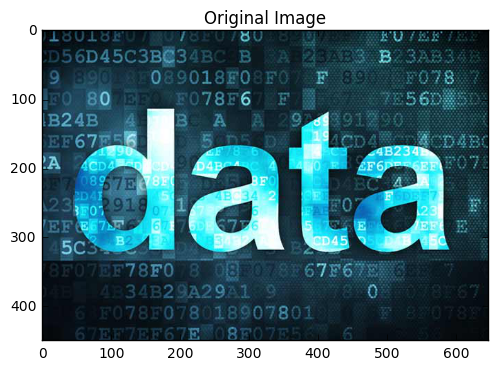

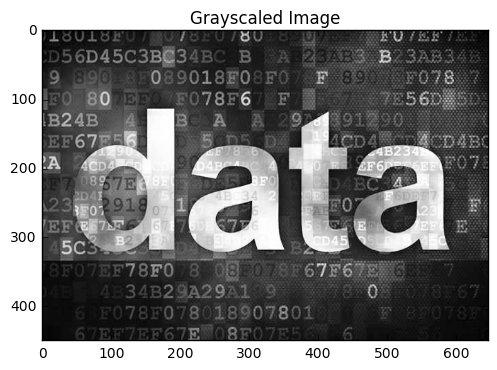

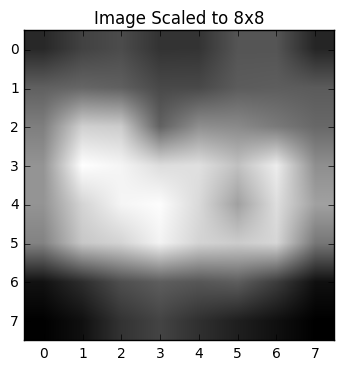

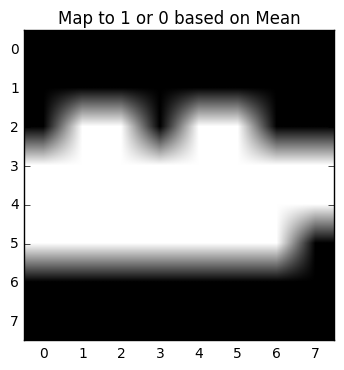

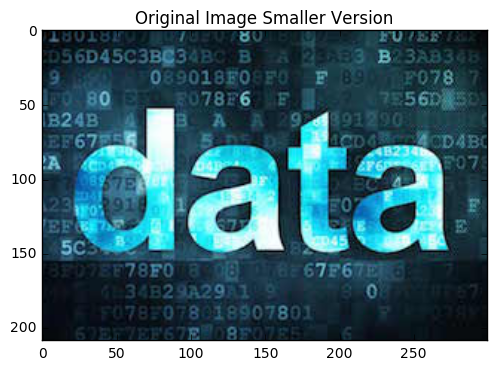

Hash of original image:          140737475117056
Hash of smaller original image:  140737475117056
MD5 hash of original image: f0694bc3cd196cd08cd153991c9dee07
MD5 hash of original image: f3d8fba735efd3e86d0ec239ada1f7dd


In [3]:
def bin2int(b):
    r = 0
    power = 0
    for bit in b:
        r |= bit << power
        power += 1
    return r

def hamming_distance(h1,h2):
    dist = 0
    xors = abs(h1) ^ abs(h2)
    while xors:
        dist += xors & 1
        xors >>= 1
    return dist

def hash_image(filename):
    img = misc.imread(filename, flatten=True)
    img = misc.imresize(img, (8,8))
    m = img.mean()
    f = np.vectorize(lambda x: 1 if (x > m) else 0)
    img = f(img)
    b = img.flatten()
    return int(bin2int(b))

#Original image
filename = "Images/BigData.jpg"
img = misc.imread(filename, flatten=False)
plt.figure()
plt.title("Original Image")
plt.imshow(img)

#grayscaled image
plt.figure()
plt.title("Grayscaled Image")
img = misc.imread(filename, flatten=True)
plt.imshow(img, cmap='Greys_r')

           
#resized to 8x8
img = misc.imresize(img, (8,8))
plt.figure()
plt.title("Image Scaled to 8x8")
plt.imshow(img, cmap='Greys_r')


#map 1 or 0 based on mean 
m = img.mean()
f = np.vectorize(lambda x: 1 if (x > m) else 0)
img = f(img)
plt.figure()
plt.title("Map to 1 or 0 based on Mean")
plt.imshow(img, cmap='Greys_r')


#create new original image, but scaled differently (for example a thumbnail of the image)
#to show it will still have similar
img = misc.imread("Images/SmallData.jpg", flatten=False)
plt.figure()
plt.title("Original Image Smaller Version")
plt.imshow(img)

plt.show()

h1 = hash_image(filename)
h2 = hash_image("Images/SmallData.jpg")
print "Hash of original image:         ", h1
print "Hash of smaller original image: ", h2
print "MD5 hash of original image:", md5.new(misc.imread(filename, flatten=False)).hexdigest()
print "MD5 hash of original image:", md5.new(misc.imread("Images/SmallData.jpg", flatten=False)).hexdigest()


As you can see, the average hashing does the trick in matching the (64 bit) hash value of the original and smaller images, but MD5 hashing does not. This is intentional as the smaller and original image are not exactly the same, but we want to find close matches.

# Database
Now, let's get started on creating a persistant file to hold information as to where are images are. 
For the basics let's just stay simple with a single table containing image file paths and hashes.
A simple sqlite3 database will suffice. Below we will set up the database (you would only ever do this once), then we will create a function that automatically updates it.
The update function is the core of keeping the database updated, this could be called either every few minutes, or simply before every query. It ensures that any changes you make within the file system (updating, moving, or changing file names) update the database as well. 

In [4]:
import sqlite3 as sql
import os
from fnmatch import fnmatch

In [5]:
# set up Images.db
os.system("rm Images.db")
os.system("touch Images.db")
db = sql.connect("Images.db")
db.execute('''CREATE TABLE images (path text PRIMARY KEY, hash integer, timestamp integer)''')
db.commit()

In [6]:
def getImages(root):
    result = {}
    pattern = "*.jpg"
    for path, subdirs, files in os.walk('Images'):
        for name in files:
            if fnmatch(name, pattern):
                result[os.path.join(path, name)] = os.path.getmtime(os.path.join(path, name))
    return result
                
def update(db):
    db_images = db.execute("SELECT path, timestamp FROM images")
    db_images = {i[0]:i[1] for i in db_images}
    images = getImages("Images")
    
    
    deletes = filter(lambda x: x not in images or images[x] > db_images[x], db_images)
    if deletes:
        print "deleted: ", deletes
        dels = map(lambda x: '"%s"'%x, deletes)
        db.execute('DELETE FROM images WHERE path IN (%s)'%(', '.join(dels)))
    
    inserts = filter(lambda x: x not in db_images or images[x] > db_images[x], images)
    if inserts:
        print "inserted: ", inserts
        imgs = map(lambda x: (x, hash_image(x), images[x]), inserts)
        db.executemany('INSERT INTO images VALUES (?,?,?)', imgs)
    db.commit()

    


getImages(root) will fetch all the images in the root folder, in our case it is Images. The images should reflect the structure defined at the beginning of the tutorial. We only consider .jpg files for now, it would be simple to add whatever other image extension of your choosing.

In [7]:
imgs = sorted(getImages("Images"))
print "\n".join(imgs)

Images/BigData.jpg
Images/Memes/Dank_Memes/img5.jpg
Images/Memes/Dank_Memes/pepe1.jpg
Images/Memes/Dank_Memes/pepe2.jpg
Images/Memes/img3.jpg
Images/Memes/img4.jpg
Images/More_Images/img6.jpg
Images/More_Images/img7.jpg
Images/SmallData.jpg
Images/img1.jpg
Images/img2.jpg


The the Images look like this:

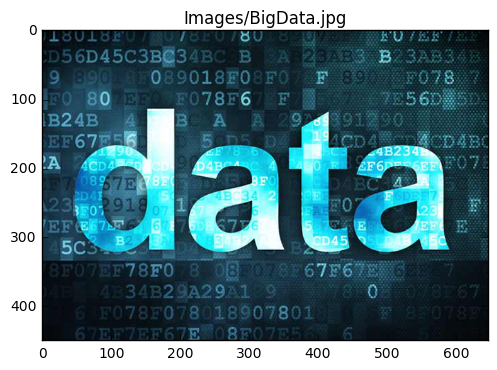

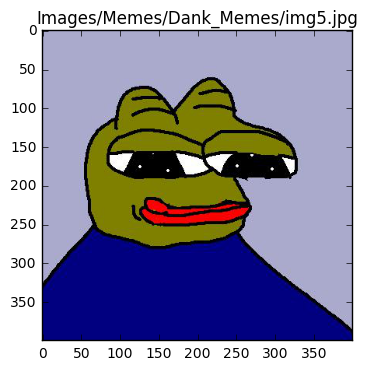

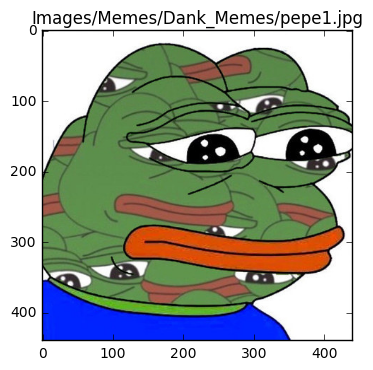

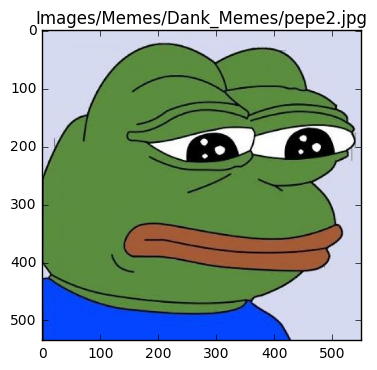

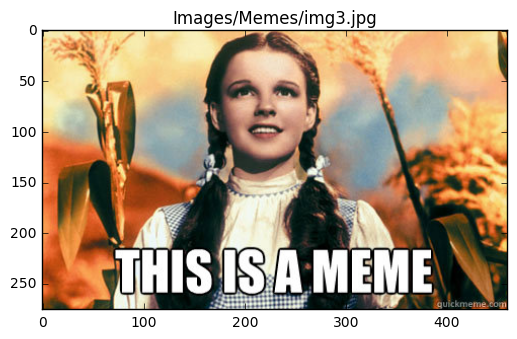

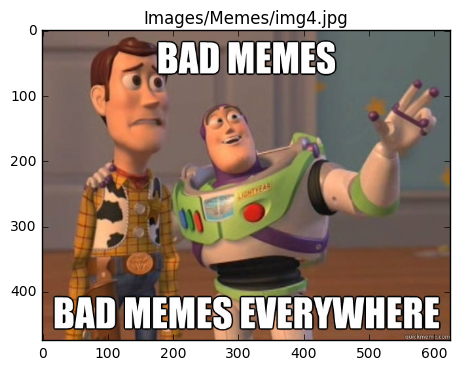

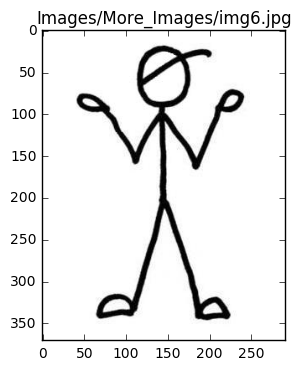

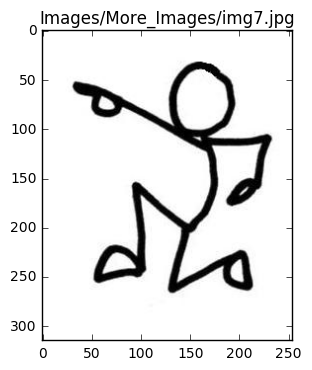

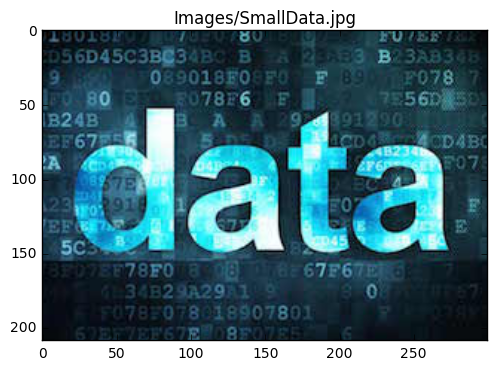

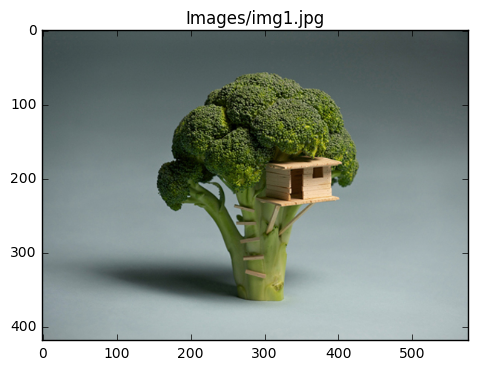

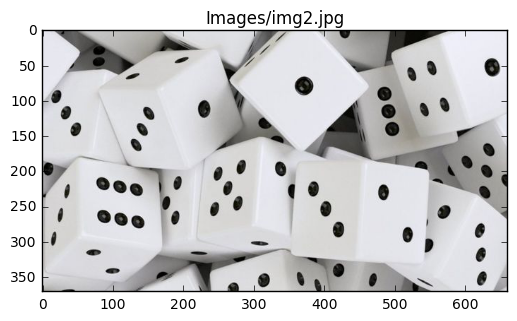

In [8]:
for img in imgs:
    plt.figure()
    plt.title(img)
    img = misc.imread(img)
    plt.imshow(img)
plt.show()

In [9]:
update(db)

inserted:  ['Images/Memes/img3.jpg', 'Images/img1.jpg', 'Images/BigData.jpg', 'Images/Memes/Dank_Memes/img5.jpg', 'Images/More_Images/img7.jpg', 'Images/SmallData.jpg', 'Images/img2.jpg', 'Images/Memes/img4.jpg', 'Images/Memes/Dank_Memes/pepe1.jpg', 'Images/Memes/Dank_Memes/pepe2.jpg', 'Images/More_Images/img6.jpg']


# Query
Now, for the final part of the tutorial, we will set up the querying for an image. This will simply take in the file path for an image, load it, hash it, and search for it within the database. We then return all images from the database that match the hash of the query image. We do not have to exactly match a given hash, perhaps we can have a similarity value, such that if the hamming distance between two hashes is low enough we can say that the images are a match. Let's let the similarity be value between 0 and 1, where 1 means the hashes have to have a hamming distance of 0, or 100 percent match between hashes.

In [10]:
import time
def query(db, path, similarity = 1):
    start = time.clock()
    update(db)
    valid_dist = int((1-similarity) * 64)
    im_hash = hash_image(path)
    def dist(x):
        return hamming_distance(im_hash, x)
    db.create_function("D", 1, dist)
    matches = list(db.execute("SELECT path, (D(hash)) FROM images where D(hash) < %d"%valid_dist))
    print "Search took: " + str(time.clock() - start) + " seconds."
    imgs = map(lambda y: y[0], sorted(matches, key = lambda x: x[1]))
    for img in imgs:
        plt.figure()
        plt.title(img)
        img = misc.imread(img)
        plt.imshow(img)
    if imgs:
        plt.show()
    else:
        print "Image not found"
    return matches

If you were to set this up as an actual python script instead of a notebook, you could have the script take the path in as an argument, and on Mac you can simply drag an image into the Terminal and it will populate it with the full path to that image file. That way you could simply run the script if ever you wanted to search for an image by simply dragging and dropping the image. 

Below we query for an example image, with a 90 percent similarity metric. You can see that the images are obviously not the same, both in size and content, but they are similar enough such that they have similar hashes.

Search took: 0.018061 seconds.


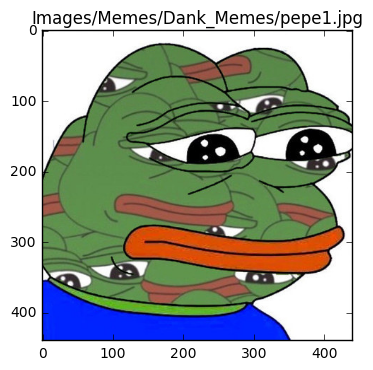

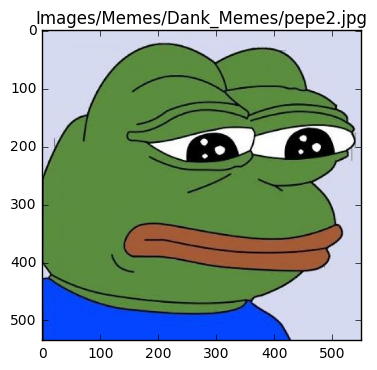

[(u'Images/Memes/Dank_Memes/pepe1.jpg', 0),
 (u'Images/Memes/Dank_Memes/pepe2.jpg', 3)]

In [11]:
query(db, "Images/Memes/Dank_Memes/pepe1.jpg",.9)